In [1]:
import h5py
import sys
import numpy as np
from scipy import io
from scipy.signal import hilbert as hilbert
from math import *;
from math import pi as m_pi

import re
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

from imagemanip import fwhm1D

import argparse

import pandas

sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\myPy')  
import stringmisc

def abshilbert(x):
    return np.abs(hilbert(x))

def gray(f,container=list):
    if container==list:
        return [f,f,f]
    if container==np.array:
        return np.array([f,f,f])
    if container==tuple:
        return (f,f,f)

plt_attr={}
plt_attr["single"]=dict(color=(0,0,1), marker="o")
plt_attr["multi_1"]=dict(color=(0.9,0.1,0), marker="^")
plt_attr["multi_2"]=dict(color=(0.5,0.5,0), marker="s" )

plt_label={}
plt_label["single"]=dict(label="single")
plt_label["multi_1"]=dict(label="4mm" )
plt_label["multi_2"]=dict(label="8mm" )

def oneLogisticNotchFiltFunc(fx,f_lo,f_hi,scale):
    return 1.0 / (1 + np.exp(scale*(fx-f_lo)) ) + 1.0 / (1 + np.exp(-scale*(fx-f_hi)) )
    
def LogisticNotchFilter(fx,f0,window,nharm,harmstep=1.0, scale=200.0):
    """
    Recursive construction of filter. 
    Actual filter is [fn + window[0], fn + window[1]] around each step
    """

    fn = f0*nharm
    f_lo = fn+window[0]
    f_hi = fn+window[1]
    F = oneLogisticNotchFiltFunc(fx,f_lo, f_hi, scale)        
        
    if (nharm-harmstep)<=1e-9:
        #lowest recursion depth (fundamental or lowest subharmonic):
        return F
    else:    
        Fb = LogisticNotchFilter(fx, f0, window, nharm-harmstep, harmstep=harmstep, scale=scale)
    
    return Fb*F

In [4]:
f.close()

In [44]:
#hfile='/Users\Vandiver\Data\Verasonics\sonalleve_20160803\CoupledRecon_Chicken_20160803.h5'
#hfile='/Users\Vandiver\Data\Verasonics\sonalleve_20160803\CoupledRecon_Phant_20160803.h5'
hfile='/Users/Vandiver/Data/Verasonics/sonalleve_20160709/CoupledRecon20160709.h5'
#hfile="/Users/Vandiver/Data/Verasonics/sonalleve_20160824/CoupledRecon_Pork_20160824.h5"

f = h5py.File(hfile,'r')

extensions = ('single','multi_1','multi_2')
probes = (1,2)
powers = [5,10,20,40,60,80]

def makename(case,power,probe,probestr=None):
    if probestr is None:
        probestr="probe%d"%probe
    
    return "%s/%s_%dW/%s"%(case,case,power,probestr)

In [43]:
def loadmaps( case,power, acqlist=None,h5f=f, timeavg=True):
    
        base=makename(case,power, 0)
    
        (nf,na,nz,nx)=h5f[base+'/cross'].shape
        Moment1Imgf=h5f[base+'/mom1'].value.reshape([2,nf*na,nz,nx])
        Moment2Imgf=h5f[base+'/mom2'].value.reshape([2,nf*na,nz,nx])
        ProbeCrossTerm = h5f[base+'/cross'].value.reshape([nf*na,nz,nx])
        
        if acqlist is None:
            varianceImage1 = Moment1Imgf[0]**2 - Moment2Imgf[0]
            varianceImage2 = Moment1Imgf[1]**2 - Moment2Imgf[1]
            coherenceTerm = 2*ProbeCrossTerm
        else:
            varianceImage1 = Moment1Imgf[0,acqlist]**2 - Moment2Imgf[0,acqlist]
            varianceImage2 = Moment1Imgf[1,acqlist]**2 - Moment2Imgf[1,acqlist]
            coherenceTerm = 2*ProbeCrossTerm[acqlist]
        if timeavg:
            varianceImage1 = np.mean(varianceImage1,axis=(0)) 
            varianceImage2 = np.mean(varianceImage2,axis=(0)) 
            coherenceTerm = np.mean(coherenceTerm,axis=(0)) 
            
        return (varianceImage1,varianceImage2,coherenceTerm)

In [77]:
list(f['single'].keys())

['noise_floor',
 'single_10W',
 'single_1W',
 'single_20W',
 'single_2W',
 'single_40W',
 'single_5W',
 'single_60W',
 'single_80W']

In [4]:
acqlist=range(1,20)

calcData=[]

varVsPower = np.zeros([len(extensions),len(powers)] )
cohVsPower = np.zeros([len(extensions),len(powers)] )

coupledMagVsPower= np.zeros([len(extensions),len(powers) ])


for ci in range(0,len(extensions)):
    case=extensions[ci]
    for pi in range(len(powers)):

        base=makename(case,powers[pi], 0)
        print(base,flush=True)
        (varianceImage1,varianceImage2,coherenceTerm) = loadmaps(case,powers[pi],acqlist=acqlist,timeavg=True,h5f=f)
        
        varVsPower[ci,pi]=np.sum(varianceImage1+varianceImage2)/2
        cohVsPower[ci,pi]=np.sum(np.abs(coherenceTerm))
        coupledMagVsPower[ci,pi]=np.sum(coherenceTerm) + varVsPower[ci,pi]


single/single_5W/probe0
single/single_10W/probe0
single/single_20W/probe0
single/single_40W/probe0
single/single_60W/probe0
single/single_80W/probe0
multi_1/multi_1_5W/probe0
multi_1/multi_1_10W/probe0
multi_1/multi_1_20W/probe0
multi_1/multi_1_40W/probe0
multi_1/multi_1_60W/probe0
multi_1/multi_1_80W/probe0
multi_2/multi_2_5W/probe0
multi_2/multi_2_10W/probe0
multi_2/multi_2_20W/probe0
multi_2/multi_2_40W/probe0
multi_2/multi_2_60W/probe0
multi_2/multi_2_80W/probe0


In [68]:
(varianceImage1,varianceImage2,coherenceTerm) = loadmaps("multi_2",60,timeavg=False,h5f=f)

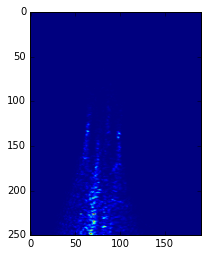

In [72]:
plt.imshow( np.sum( varianceImage1[1:20],axis=0) )

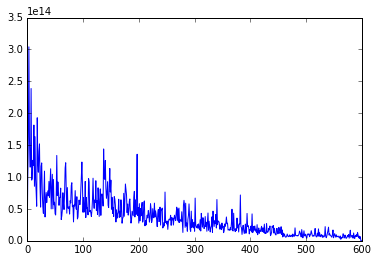

In [73]:
plt.plot( np.sum( varianceImage1[:,100:150,50:100], axis=(1,2)) )

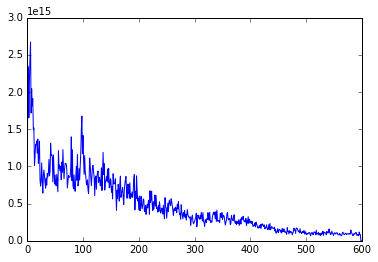

In [74]:
plt.plot( np.sum( varianceImage1, axis=(1,2)) )

acqlist=range(1,100)

In [36]:
tsVar_totVsPower=np.zeros_like(varVsPower)
tsVar_filtVsPower=np.zeros_like(varVsPower)
tsVar_unfiltVsPower=np.zeros_like(varVsPower)

for ci in range(0,len(extensions)):
    case=extensions[ci]
    for pi in range(len(powers)):
        
        for probe in probes:
            extstr=makename(case,powers[pi], probe)
            
            tsVar_totVsPower[ci,pi]+= np.sum(f[extstr+"/var/tot"][:,acqlist])
            tsVar_filtVsPower[ci,pi]+= np.sum(f[extstr+"/var/filt"][:,acqlist])
            tsVar_unfiltVsPower[ci,pi]+= np.sum(f[extstr+"/var/unfiltFFT"][:,acqlist])

In [5]:
extstr

NameError: name 'extstr' is not defined

In [9]:
list(f['multi_1/multi_1_5W/probe1/var'].keys())

['filt', 'sumspec', 'tot', 'unfiltFFT']

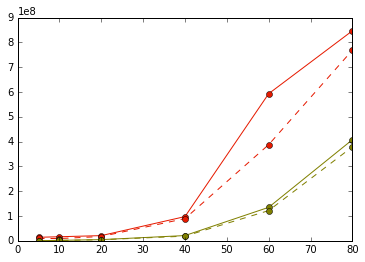

In [37]:
for ci in range(1,len(extensions)):
    plt.plot( powers, tsVar_filtVsPower[ci],'-o', **plt_attr[extensions[ci]])
    plt.plot( powers, tsVar_unfiltVsPower[ci],'--o', **plt_attr[extensions[ci]])

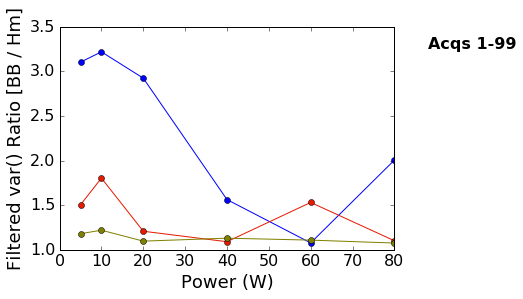

In [38]:
for ci in range(0,len(extensions)):
    plt.plot( powers, tsVar_filtVsPower[ci]/tsVar_unfiltVsPower[ci],'-o', **plt_attr[extensions[ci]])
    
plt.ylabel('Filtered var() Ratio [BB / Hm]',fontsize=18)
plt.xlabel('Power (W)',fontsize=18)
plt.gca().tick_params(labelsize=16)
plt.text(1.1,0.9,'Acqs %d-%d'%(acqlist[0],acqlist[-1]),transform=plt.gca().transAxes,fontsize=16, color='k',fontweight='bold')

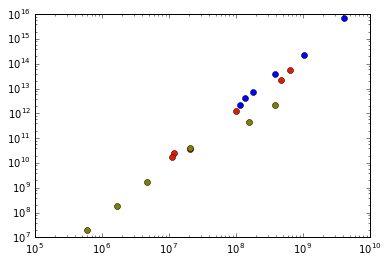

In [8]:
for ci in range(0,len(extensions)):
    plt.loglog( tsVar_totVsPower[ci], varVsPower[ci],'o', **plt_attr[extensions[ci]])
    

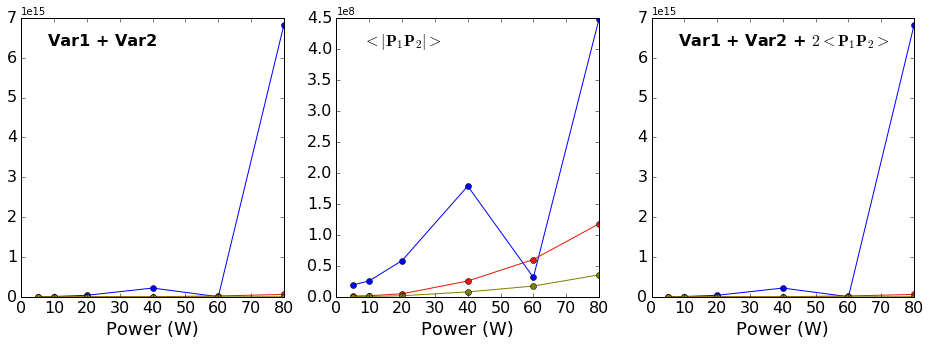

In [9]:
fig=plt.figure(figsize=(16,5))
ax1=fig.add_subplot(131)
ax2=fig.add_subplot(132)
ax3=fig.add_subplot(133)
for ci in range(0,len(extensions)):
    case=extensions[ci]
    ax1.plot(powers, varVsPower[ci], '-o', **plt_attr[case])
    
    ax2.plot(powers, cohVsPower[ci], '-o', **plt_attr[case])
    ax3.plot(powers, coupledMagVsPower[ci], '-o', **plt_attr[case])
    
ax1.text(0.1,0.9,'Var1 + Var2',transform=ax1.transAxes, fontsize=16, color='k',fontweight='bold')
ax2.text(0.1,0.9,r'$\mathbf{<|P_1 P_2|>}$',transform=ax2.transAxes, fontsize=16, color='k',fontweight='bold')
ax3.text(0.1,0.9,'Var1 + Var2 + $2\mathbf{<P_1 P_2>}$',transform=ax3.transAxes, fontsize=16, color='k',fontweight='bold')
for ax in (ax1,ax2,ax3):
    ax.set_xlabel('Power (W)',fontsize=18)
    ax.tick_params(labelsize=16)


In [ ]:
base=makename('multi_2',60,0)
Moment1Imgf=f[base+'/mom1']
Moment2Imgf=f[base+'/mom2']
ProbeCrossTerm = f[base+'/cross']
varianceImage1 = np.mean(Moment1Imgf[0]**2,axis=(0,1)) - np.mean(Moment2Imgf[0],axis=(0,1))
varianceImage2 = np.mean(Moment1Imgf[1]**2,axis=(0,1)) - np.mean(Moment2Imgf[1],axis=(0,1)) 
coherenceTerm = 2*np.mean(ProbeCrossTerm,axis=(0,1))
summedImage = varianceImage1+varianceImage2
coupledImage = summedImage + coherenceTerm  

In [ ]:
plt.imshow(varianceImage1)
plt.colorbar()

In [ ]:
plt.imshow(summedImage)
plt.colorbar()

In [ ]:
plt.imshow(np.abs(coherenceTerm))
plt.colorbar()

In [13]:
(varianceImage1,varianceImage2,coherenceTerm) = loadmaps("multi_2",60,acqlist=range(1,20),timeavg=False,h5f=f)

In [7]:
varianceImage1.shape

(19, 250, 191)

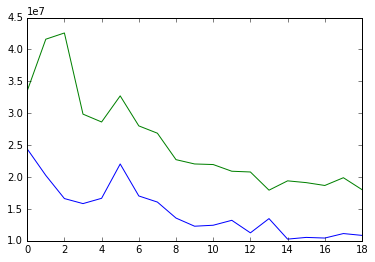

In [8]:
plt.plot( np.sum(varianceImage1, axis=(1,2)) )
plt.plot( np.sum(varianceImage2, axis=(1,2)) )
#plt.plot( np.sum(coherenceTerm**2, axis=(1,2)) )

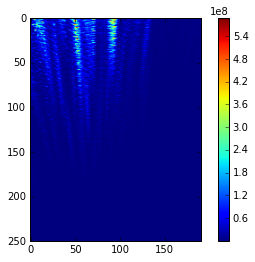

In [15]:
plt.imshow( np.mean( varianceImage2[0:],axis=0))
plt.colorbar()

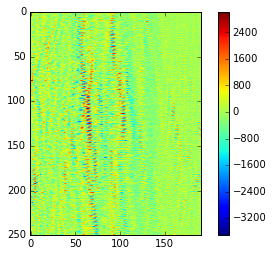

In [16]:
plt.imshow( np.mean( (coherenceTerm )[0:],axis=0))
plt.colorbar()

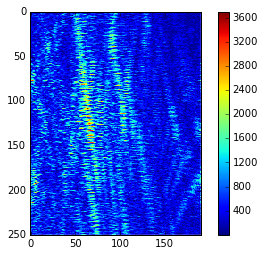

In [17]:
plt.imshow( abshilbert((np.mean( (coherenceTerm )[:],axis=0) ) ), interpolation='none')
plt.colorbar()

In [39]:
chsumSpecVsAcq = f["single/single_60W/probe1/var/sumspec"]
endidx=chsumSpecVsAcq.attrs["endidx"]
fx=chsumSpecVsAcq.attrs["fMHz"][0:endidx]
harmonicFilter=chsumSpecVsAcq.attrs["filter"][0:endidx]
NFFT=chsumSpecVsAcq.attrs["NFFT"]

In [40]:
chsumSpecVsAcq1 = f["multi_1/multi_1_60W/probe1/var/sumspec"]
chsumSpecVsAcq2 = f["multi_2/multi_2_60W/probe1/var/sumspec"]

In [19]:
ix=fx<4
(ww,lox,hix)=fwhm1D(fx[ix],harmonicFilter[ix],quantile=10**(-3/10))
ww

0.39326124237263116

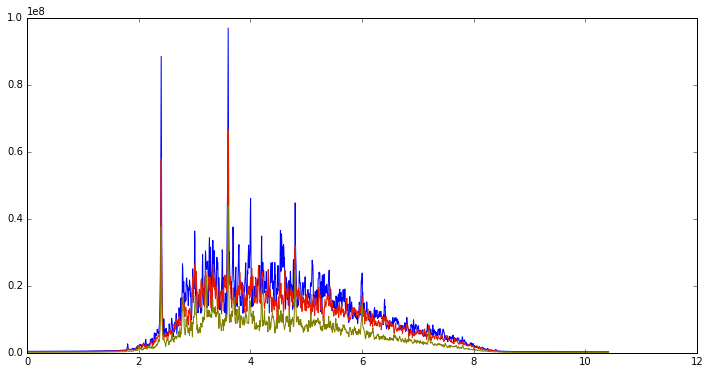

In [41]:
plt.figure(figsize=(12,6))
plt.plot( fx,chsumSpecVsAcq[1,:], color=plt_attr["single"]['color'])
plt.plot( fx,chsumSpecVsAcq1[1,:],  color=plt_attr["multi_1"]['color'])
plt.plot( fx,chsumSpecVsAcq2[1,:],  color=plt_attr["multi_2"]['color'])

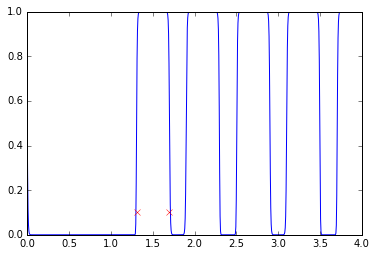

In [6]:
plt.plot( fx[ix],harmonicFilter[ix])
plt.plot( [lox,hix], [0.1,0.1], 'xr')

In [11]:
f0MHz=1.2;nharm=20
harmonicFilter = LogisticNotchFilter(fx,f0MHz,[-f0MHz, 0.1],1,harmstep=1.0,scale=200)
harmonicFilter *= LogisticNotchFilter(fx,f0MHz,[-0.075, 0.075],nharm,harmstep=1.0,scale=200)        
harmonicFilter *= LogisticNotchFilter(fx,f0MHz*0.5,[-0.025, 0.025],nharm,harmstep=1.0,scale=200)
harmonicFilter *= LogisticNotchFilter(fx,f0MHz/3,[-0.025, 0.025],nharm,harmstep=1.0,scale=200)
#harmonicFilter *= LogisticNotchFilter(fx,f0MHz/4,[-0.025, 0.025],nharm,harmstep=1.0,scale=200)

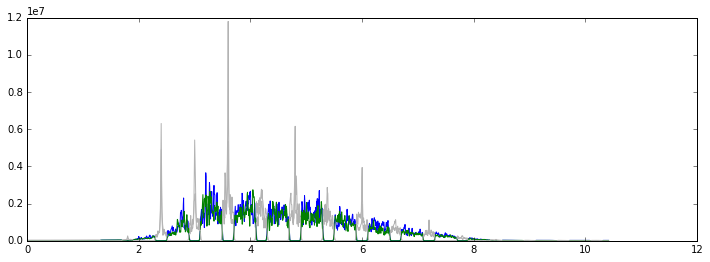

In [30]:
plt.figure(figsize=(12,4))
plt.plot( fx,chsumSpecVsAcq[1,:]*harmonicFilter)
plt.plot( fx,chsumSpecVsAcq[1,:]*(1-harmonicFilter), color=gray(0.7))
plt.plot( fx,chsumSpecVsAcq[400,:]*harmonicFilter)
plt.plot( fx,chsumSpecVsAcq[400,:]*(1-harmonicFilter), color=gray(0.7))

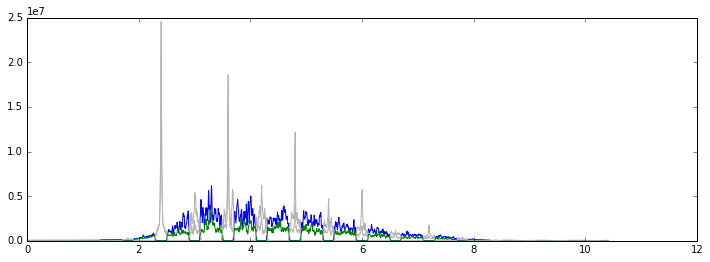

In [32]:
plt.figure(figsize=(12,4))
plt.plot( fx,chsumSpecVsAcq[1,:]*harmonicFilter)
plt.plot( fx,chsumSpecVsAcq[1,:]*(1-harmonicFilter), color=gray(0.7))
plt.plot( fx,chsumSpecVsAcq[400,:]*harmonicFilter)
plt.plot( fx,chsumSpecVsAcq[400,:]*(1-harmonicFilter), color=gray(0.7))

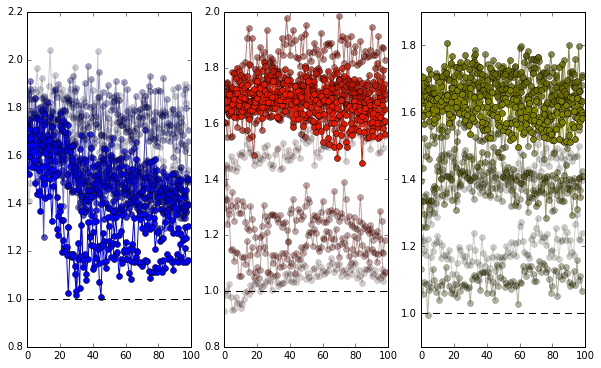

In [20]:
powers=[5,10,20,40,60,80]
cases=['single','multi_1','multi_2']
probes=[1,2]

# 'probe#/BB' data is the filtered noise per acquistion. Do for the BB and Harmonics cases, take ratio


chsumSpecVsAcq = f["single/single_5W/probe1/var/sumspec"]
endidx=chsumSpecVsAcq.attrs["endidx"]
fx=chsumSpecVsAcq.attrs["fMHz"][0:endidx]
harmonicFilter=chsumSpecVsAcq.attrs["filter"][0:endidx]

ratios=[]
acqA=1; acqB=100
fig=plt.figure(figsize=(10,6))

for ci in range(0,len(cases)):
    plt.subplot("13%d"%(ci+1))
    casergb= np.array(plt_attr[cases[ci]]["color"])
    for pi in range(0,len(powers)):
        
        (varianceImage1,varianceImage2,coherenceTerm) = loadmaps(cases[ci],powers[pi],acqlist=range(acqA,acqB),timeavg=True,h5f=f)
        
        imgmags = [ np.sum(varianceImage1), np.sum(varianceImage2)]
        for probe in probes:
            extstr=makename(cases[ci],powers[pi], probe)
            
            
            ovflw=f[extstr+"/var/tot"].attrs["overflows"]
            chsumSpecVsAcq = f[extstr+"/var/sumspec"]
            
            #to adjust by weighting factor or not?...
            wBB=1.0/np.sum(harmonicFilter)
            wHH=1.0/np.sum(1-harmonicFilter)
            wBB=1
            wHH=1
            BB = (np.sum( chsumSpecVsAcq[acqA:acqB]*harmonicFilter,axis=1 )*wBB)
            HH = (np.sum( chsumSpecVsAcq[acqA:acqB]*(1-harmonicFilter),axis=1 )*wHH)
            
            CavIndex = np.mean(np.sum(np.log10( chsumSpecVsAcq[acqA:acqB] ) ,axis=1))
            #accumratio=np.mean(BB) / np.mean(HH)
            ratio=BB/HH
            accumratio=np.mean(ratio)
            #accumratio=np.mean(h5BB[extstr+"/BB"][acqA:acqB])**2 / np.mean(h5HH[extstr+"/BB"][acqA:acqB])**2
            
            #colorchan=np.mod(ci,3)
            colormag=(.95*(pi+1.0)/len(powers) + 0.05)
            #rgb=[0,0,0]
            #rgb[colorchan]=colormag
            rgb = casergb*(colormag)
            
            plt.plot(ratio,'-o',color=rgb,label=extstr,alpha=colormag)
            plt.plot(plt.xlim(),[1,1],'k--',label=None)
            ratios.append(dict(power=powers[pi],case=cases[ci],imgmag=imgmags[probe-1],cavidx=CavIndex, 
                               probe=probe,ratio=accumratio,over=ovflw,bb=np.mean(BB),hh=np.mean(HH) ))
    
#h5BB[makename("single",5,2)+"/BB"][0:580]/h5HH[makename("single",5,2)+"/BB"][0:580]
ratio_frame=pandas.DataFrame(ratios)

pows=ratio_frame.groupby(['case','power'])

avgdf=pows.aggregate(dict(ratio=np.mean,over=sum,bb=np.mean,hh=np.mean,cavidx=np.mean))


In [18]:
varianceImage1.shape

(250, 191)

In [93]:
avgdf=pows.aggregate(dict(ratio=np.mean,over=sum,bb=np.mean,hh=np.mean,cavidx=np.mean))

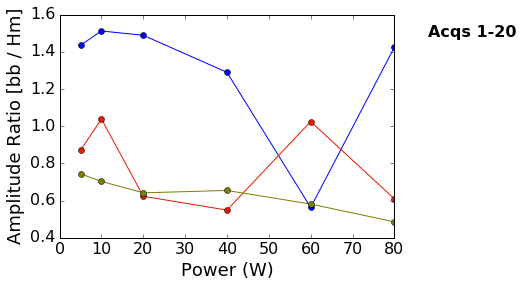

In [43]:
for case in ('single','multi_1','multi_2'):
    ff=avgdf.loc[case]
    plt.plot(ff.index,ff.get("ratio"),'-o',label=case,**plt_attr[case])

    
plt.ylabel('Amplitude Ratio [bb / Hm]',fontsize=18)
plt.xlabel('Power (W)',fontsize=18)
plt.gca().tick_params(labelsize=16)
plt.text(1.1,0.9,'Acqs %d-%d'%(acqA,acqB),transform=plt.gca().transAxes,fontsize=16, color='k',fontweight='bold')

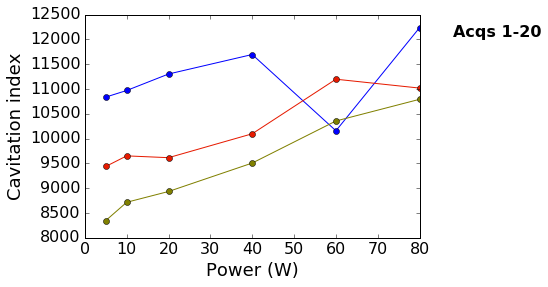

In [44]:
for case in ('single','multi_1','multi_2'):
    ff=avgdf.loc[case]
    plt.plot(ff.index,ff.get("cavidx"),'-o',label=case,**plt_attr[case])
    
plt.ylabel('Cavitation index',fontsize=18)
plt.xlabel('Power (W)',fontsize=18)
plt.gca().tick_params(labelsize=16)
plt.text(1.1,0.9,'Acqs %d-%d'%(acqA,acqB),transform=plt.gca().transAxes,fontsize=16, color='k',fontweight='bold')

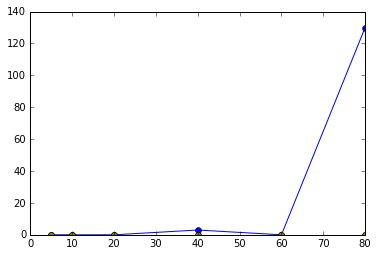

In [16]:
for case in ('single','multi_1','multi_2'):
    ff=avgdf.loc[case]
    plt.plot(ff.index,ff.get("over"),'-o',label=case,**plt_attr[case])

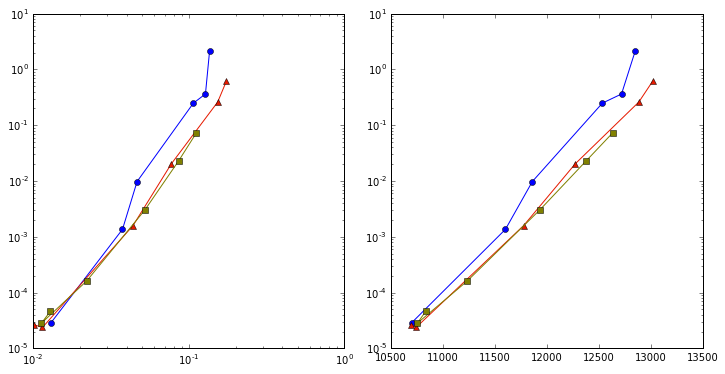

In [32]:
fig=plt.figure(figsize=(12,6))
gsPow=gridspec.GridSpec(1,2,wspace=0.15,hspace=0.25)

ax=fig.add_subplot(gsPow[0,0])
for case in ('single','multi_1','multi_2'):
    df=ratio_frame.query("probe==1 and case=='%s'"%case)
    ax.plot( df['bb'] /(1e6*250*191), df['imgmag'] /(1e12*250*191), **plt_attr[case] )
ax.set_xscale('log')  
ax.set_yscale('log')  
ax=fig.add_subplot(gsPow[0,1])
for case in ('single','multi_1','multi_2'):
    df=ratio_frame.query("probe==1 and case=='%s'"%case)
    ax.plot( df['cavidx'], df['imgmag'] /(1e12*250*191), **plt_attr[case] )

ax.set_yscale('log') 

In [48]:
f['single/single_10W/probe1/var/filt']

<HDF5 dataset "filt": shape (128, 600), type "<f8">

In [32]:
df

,bb,case,hh,imgmag,over,power,probe,ratio
32,2.852195e+08,multi_2,3.346284e+08,5.857988e+11,0,1,1,0.852547
33,3.507421e+08,multi_2,3.850966e+08,1.013906e+12,28,1,2,0.911366
34,2.160218e+08,multi_2,2.220949e+08,7.025233e+10,0,2,1,0.975644
35,3.240506e+08,multi_2,2.902590e+08,3.063132e+11,0,2,2,1.121334
36,1.658560e+08,multi_2,1.246233e+08,7.779684e+09,0,5,1,1.348348
37,2.189153e+08,multi_2,1.540034e+08,3.566290e+10,0,5,2,1.449166
38,2.887039e+08,multi_2,2.489965e+08,8.636259e+10,0,10,1,1.173491
39,4.495110e+08,multi_2,4.045444e+08,1.161355e+12,0,10,2,1.114857
40,1.318103e+09,multi_2,8.199600e+08,1.539851e+13,0,20,1,1.609255
41,1.388140e+09,multi_2,8.072311e+08,2.639834e+13,0,20,2,1.720548


## Image mag vs BB mag vs BB/H ratio vs Time vs Power

In [91]:
#image mag vs time

chsumSpecVsAcq = f["single/single_5W/probe1/var/sumspec"]
endidx=chsumSpecVsAcq.attrs["endidx"]
fx=chsumSpecVsAcq.attrs["fMHz"][0:endidx]
harmonicFilter=chsumSpecVsAcq.attrs["filter"][0:endidx]

acqlist=list(range(1,100))
dout=[]

powers=[5,10,20,40,60,80]

for ci in range(0,len(cases)):
    case=extensions[ci]
    for pi in range(len(powers)):

        for probe in probes:
            extstr=makename(cases[ci],powers[pi], probe)
            
            ovflw=f[extstr+"/var/tot"].attrs["overflows"]
            chsumSpecVsAcq = f[extstr+"/var/sumspec"]
            
            wBB=1
            wHH=1
            BB = (np.sum( chsumSpecVsAcq[acqlist]*harmonicFilter,axis=1 )*wBB)
            HH = (np.sum( chsumSpecVsAcq[acqlist]*(1-harmonicFilter),axis=1 )*wHH)
            totvar = np.sum( f[extstr+"/var/tot"],axis=0 )[acqlist]
            tot = np.sum(totvar )
            dout.append(dict(power=powers[pi],case=cases[ci],probe=probe,tot=tot,totvar=totvar,over=ovflw,bb=BB,hh=HH ))

magframe=pandas.DataFrame(dout)

In [22]:
totvar.shape

(19,)

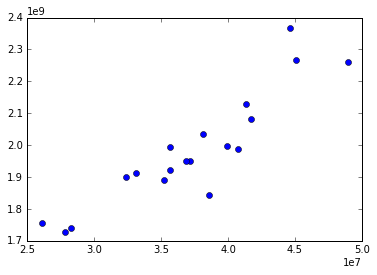

In [58]:
qry = magframe.query('power==80 & case=="single" & probe==1').iloc[0]
plt.plot( qry.totvar,  qry.bb,'o')

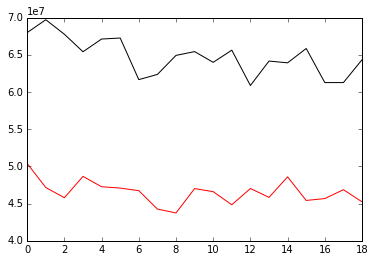

In [66]:
qry = magframe.query('power==20 & case=="multi_2" & probe==1').iloc[0]
plt.plot( qry.bb,'r')
plt.plot( qry.hh,'k')

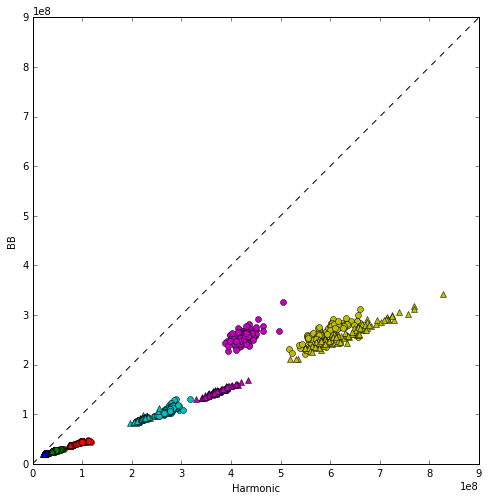

In [92]:
plt.figure(figsize=(8,8))

powercolor=['b','g','r','c','m','y','k','0.5']
    
    
for pi in range(len(powers)):
    qry = magframe.query('power==%d & case=="single" & probe==1'%powers[pi]).iloc[0]
    plt.plot( qry.hh,  qry.bb,'o', color=powercolor[pi])
    
for pi in range(len(powers)):
    qry = magframe.query('power==%d & case=="multi_2" & probe==1'%powers[pi]).iloc[0]
    plt.plot( qry.hh,  qry.bb,'^', color=powercolor[pi])
    

plt.xlabel('Harmonic')
plt.ylabel('BB')

#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.plot(plt.xlim(),plt.xlim(),'k--')

In [ ]:
plt.figure(figsize=(8,8))

powercolor=['b','g','r','c','m','y','k','0.5']
    
    
for pi in range(len(powers)):
    qry = magframe.query('power==%d & case=="single" & probe==1'%powers[pi]).iloc[0]
    plt.plot( qry.hh,  qry.bb / qry.hh,'o', color=powercolor[pi])
    
for pi in range(len(powers)):
    qry = magframe.query('power==%d & case=="multi_2" & probe==1'%powers[pi]).iloc[0]
    plt.plot( qry.hh,  qry.bb,'^', color=powercolor[pi])
    

plt.xlabel('Harmonic')
plt.ylabel('BB')

#plt.gca().set_xscale('log')
#plt.gca().set_yscale('log')
plt.plot(plt.xlim(),plt.xlim(),'k--')

In [10]:
(2048/20.8e6)

9.846153846153846e-05

In [ ]:
grouped=magframe.groupby(['case','power'])

avgdf=grouped.aggregate(dict(ratio=np.mean,over=sum,bb=np.mean,hh=np.mean))

In [35]:
import geom
import transducers
import sonalleve
import RSgpuPySwig

import PBHE_CUDA
import sys
sys.path.append('C:\\Users\\vchaplin\\Documents\\HiFU\\code\\AblationSims')
import ablation_utils
import importlib


In [94]:
f0=1.2e6
c0=1540
rho=1000
Cp=3700
ktherm=0.6

Ispta0=1.0e7

T0=37
k0 = 2*pi*f0/c0

xw=1.2
yw=1.2
zmin=14.0
zmax=14.01

Nt=3
Nx=128
Ny=128
Nz=3

dataType = np.float32

simgrid = ablation_utils.makeSimPhysGrid(nt=Nt,nx=Nx,ny=Ny,nz=Nz,rho=rho,ktherm=ktherm,f0=f0,Cp=Cp,c0=c0,
    dt=0.1, xr=[-xw/2.0, xw/2.0], yr=[-yw/2.0, yw/2.0],zr=[zmin,zmax])


CEMfinal =np.zeros([Nx,Ny,Nz],dtype=dataType)
Rbase=np.zeros([Nx,Ny,Nz],dtype=dataType)
Tmax=np.zeros([Nx,Ny,Nz],dtype=dataType)

[T4d,tdot3d,kt3d,rhoCp3d,Dtxyz]=[simgrid[k] for k in tuple('T,Tdot,kt,rhoCp,dtxyz'.split(','))]

[xrp,yrp,zrp]=[simgrid[k] for k in tuple('xrp,yrp,zrp'.split(','))]
(dx,dy,dz,dt)=simgrid['dtxyz']

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)

zplane=0.14
focplaneZpix=np.where(np.logical_and( (zrp[1:-1]-zplane>=0) , (zrp[0:-2]-zplane<=0) ))[0][0]

gxp,gyp,gzp = np.meshgrid(xrp, yrp, zrp, sparse=False, indexing='ij')
calcGridDist= lambda rr: np.sqrt((gxp-rr[0])**2 + (gyp-rr[1])**2 + (gzp-rr[2])**2)


voxml = dx*dy*dz*1e6



In [146]:
def L2norm(arg):
    return np.sqrt(np.sum(np.abs(arg)**2))


uxyz = sonalleve.get_sonalleve_xdc_vecs()
N = uxyz.shape[0]
unvecs = np.apply_along_axis(lambda x: x / np.sqrt(np.sum(x**2)), 1, [0.0,0.0,0.14] - uxyz )
uamp0 = np.ones(N) / N

#P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, np.linspace(-0.003,0.003,60), np.linspace(-0.003,0.003,60), 0.14 + np.linspace(-0.003,0.003,60))

RSkeys=dict(subsampN=10, ROC=0.14, subsampDiam=0.0066, gpublocks=512)

uamp0u = transducers.get_focused_element_vals( k0, uxyz, [[0.00,0,0.14]], np.ones(1), L1renorm=1 )

C:\Users\Vandiver\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


In [148]:
P0u = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0u, xrp, yrp, zrp, **RSkeys   )

In [150]:
l1renorm=1/np.max(np.abs(P0u))
uamp0 = l1renorm*uamp0u/np.sum(np.abs(uamp0u))

In [151]:
np.sum(np.abs(uamp0))

1.0037729624463905

In [149]:
np.max(np.abs(P0u))

0.99624121929206488

In [152]:


M=4
pxyz,junk=geom.ring(4.0,M,z=140,rot=22.5*m_pi/180)
uamp1 = transducers.get_focused_element_vals( k0, uxyz, pxyz*1e-3, np.ones(M)*np.exp(1j*np.arange(0,M)*pi), L1renorm=l1renorm )

M=4
pxyz2,junk=geom.ring(8.0,M,z=140,rot=22.5*m_pi/180)
uamp2 = transducers.get_focused_element_vals( k0, uxyz, pxyz2*1e-3, np.ones(M)*np.exp(1j*np.arange(0,M)*pi), L1renorm=l1renorm )

P0 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp0, xrp, yrp, zrp, **RSkeys   )
P1 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp1, xrp, yrp, zrp, **RSkeys   )
P2 = transducers.calc_pressure_field_cuda(k0, uxyz, unvecs, uamp2, xrp, yrp, zrp, **RSkeys   )

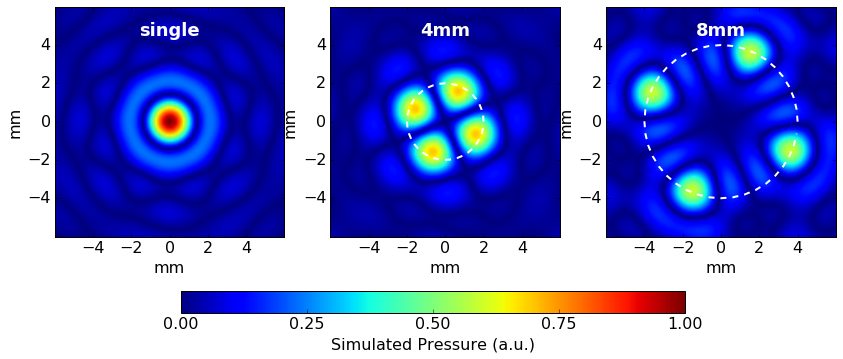

In [193]:
extYX=xrp[[0,-1,0,-1]]*1000



fig=plt.figure(figsize=(14,6))
ax1=fig.add_subplot(131)

ax1.text(0,4.5,'single',color='w',horizontalalignment='center',fontsize=18,fontweight='bold')

im1=plt.imshow( np.abs(P0[:,:,0]).transpose(),extent=extYX,vmin=0,vmax=1)

ax2=fig.add_subplot(132)
ax2.text(0,4.5,'4mm',color='w',horizontalalignment='center',fontsize=18,fontweight='bold')

plt.imshow( np.abs(P1[:,:,0]).transpose(),extent=extYX,vmin=0,vmax=1)
(ring,junk)=geom.ring(4, 40)
plt.plot( ring[:,0], ring[:,1], 'w--',linewidth=2.0)


ax3=fig.add_subplot(133)
ax3.text(0,4.5,'8mm',color='w',horizontalalignment='center',fontsize=18,fontweight='bold')
plt.imshow( np.abs(P2[:,:,0]).transpose(),extent=extYX,vmin=0,vmax=1)
(ring,junk)=geom.ring(8, 40)
plt.plot( ring[:,0], ring[:,1], 'w--',linewidth=2.0)


ax=fig.add_axes([0.25, 0.07, 0.5, 0.05])

cb=plt.colorbar(mappable=im1,orientation='horizontal',cax=ax)
cb.set_cmap(image.cm.hot)
cb.set_ticks([0,0.25,0.5,0.75,1.0])
 
cb.set_label('Simulated Pressure (a.u.)',fontsize=16)
cb.ax.tick_params(labelsize=16)

for a in [ax1,ax2,ax3]:
    a.tick_params(labelsize=16)
    a.set_xticks([-4,-2,0,2,4])
    a.set_yticks([-4,-2,0,2,4])
    a.set_xlabel('mm',fontsize=16)
    a.set_ylabel('mm',fontsize=16)

In [194]:
fig.savefig("/Users/Vandiver/OneDrive/Documents/Multi-foc Paper/BeamSims.png")
plt.close(fig)

In [197]:
np.max(np.abs(P0[:,:,0])), np.max(np.abs(P1[:,:,0])), np.max(np.abs(P2[:,:,0]))

(0.99999999999999867, 0.69759640458722283, 0.59152402828584694)

In [123]:
list( map(lambda im: np.max(np.abs(im[:,:,0])), [P0, P1, P2]) )

[187500.87073207233, 136558.497131921, 115794.22111261074]

In [37]:
ublur= np.sqrt(np.sum( (uxyz-[0.0, 0.0, 0.15])**2, axis=1))/0.14

In [43]:
ublur = (0.7 - np.sqrt(np.sum( (uxyz[:,0:2])**2, axis=1)))/0.7

In [181]:
ring.shape

(6, 3)

In [53]:

zax=np.arange(0.08,0.17,0.0001)
xax=np.zeros_like(zax)
Pz=transducers.calc_pressure_profile_cuda(k0,uxyz,unvecs,uamp0, xax,xax,zax,**RSkeys )
Pz2=transducers.calc_pressure_profile_cuda(k0,uxyz,unvecs,uamp0*ublur, xax,xax,zax,**RSkeys )



xax=np.arange(-0.01,0.01,0.0001)
zax=np.zeros_like(xax)+0.14
Px=transducers.calc_pressure_profile_cuda(k0,uxyz,unvecs,uamp0, xax,xax,zax,**RSkeys )
Px2=transducers.calc_pressure_profile_cuda(k0,uxyz,unvecs,uamp0*ublur, xax,xax,zax,**RSkeys )

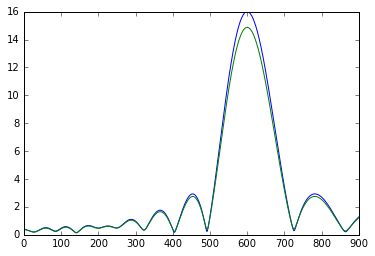

In [54]:
plt.plot(np.abs(Pz))
plt.plot(np.abs(Pz2))

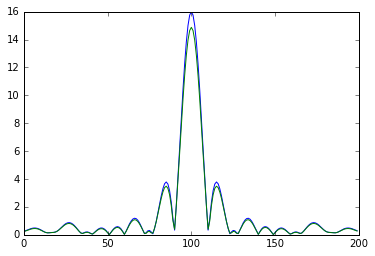

In [55]:
plt.plot(np.abs(Px))
plt.plot(np.abs(Px2))